In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [36]:
dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                               create_validation_set=True)
# type(dict_dfs['df_test_pa'])

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Created validation set with 8898 entries


In [39]:
val_or_test = 'test'

dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                create_validation_set=True if val_or_test == 'val' else False)
tmp = gpu.predict_using_buffer(dict_dfs=dict_dfs, dict_dfs_species=dict_dfs_species,
                            save_pred=True, method=f'lc-specific', buffer_deg=0.3,
                            eval_mode=val_or_test)
if val_or_test == 'val':
    f1_score = gpu.compute_f1_score_dicts(dict_val_species, tmp)
    print(f'F1 score: {f1_score}')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
    LandCover  count
0         0.0     25
1         1.0     15
2         2.0     18
3         4.0     22
4         5.0     16
5         8.0     20
6         9.0     16
7        10.0     19
8        11.0     14
9        12.0     17
10       13.0     16
11       14.0     17
12       15.0     11
13       16.0     12
14       17.0     13


 43%|████▎     | 2049/4716 [00:13<00:17, 149.13it/s]

No nearby points for surveyId: 1695841 (LC: 13.0)


100%|██████████| 4716/4716 [00:31<00:00, 151.01it/s]

Predictions done (4715 total). No nearby points: 1.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-buffer-lc-0.3-lc-specific_2024-04-18_22-53.csv


In [32]:
tmp

,lng,lat,year,surveyId,geometry,Elevation,LandCover,Bio1,Bio2,Bio3,...,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
26108,8.46318,56.02289,2017,1276701,POINT (8.46318 56.02289),19.0,5.0,2816,43,2,...,2884,2754,9632,1247,429,280,3286,1651,2340,2355
67032,8.37565,56.17565,2017,3288416,POINT (8.37565 56.17565),12.0,5.0,2818,35,1,...,2884,2757,9171,1203,406,288,3162,1557,2557,1995
26071,8.44744,56.15897,2019,1274470,POINT (8.44744 56.15897),28.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
34794,8.44535,56.15905,2019,1702631,POINT (8.44535 56.15905),28.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
34735,8.44792,56.15915,2019,1699855,POINT (8.44792 56.15915),29.0,5.0,2816,41,2,...,2884,2754,9733,1261,438,279,3318,1673,2703,2368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10850,8.59644,56.29672,2019,530563,POINT (8.59644 56.29672),22.0,5.0,2815,53,2,...,2886,2750,9560,1209,452,259,3191,1682,2323,2364
57771,8.58748,56.29928,2019,2842242,POINT (8.58748 56.29928),23.0,5.0,2815,52,2,...,2886,2750,9539,1208,450,260,3188,1677,2317,2357
7138,8.58928,56.34263,2019,349859,POINT (8.58928 56.34263),33.0,5.0,2815,54,2,...,2886,2750,9326,1181,442,260,3118,1638,2264,2306
31530,8.59174,56.34313,2019,1539083,POINT (8.59174 56.34313),27.0,5.0,2815,54,2,...,2886,2750,9335,1181,443,259,3117,1642,2266,2310


## Predictions

In [53]:
(df_train, df_test), (df_train_species, df_val_species) = dlu.create_full_pa_ds(val_or_test='test')

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [59]:
df_train_species

,speciesId,surveyId
0,6874,212
1,476,212
2,11157,212
3,8784,212
4,4530,212
...,...,...
1483632,53,3919655
1483633,5071,3919655
1483634,1889,3919655
1483635,10600,3919655


In [11]:
_[1]

,speciesId,surveyId
276,5900,729
288,9368,729
287,53,729
286,10255,729
285,10600,729
...,...,...
1483598,3067,3919620
1483597,4077,3919620
1483596,9816,3919620
1483600,540,3919620


In [12]:
## create scipy sparse matrix, fill by row:
from scipy.sparse import csr_matrix

df_species_tmp = _[1]
n_rows = df_species_tmp.surveyId.nunique()
n_cols = df_species_tmp.speciesId.max()

mat = csr_matrix((n_rows, n_cols), dtype=np.int32)
for row, surveyId in tqdm(enumerate(df_species_tmp.surveyId.unique())):
    tmp_df = df_species_tmp.loc[df_species_tmp.surveyId == surveyId]
    cols = tmp_df.speciesId.values - 1
    ## fill mat:
    mat[row, cols] = 1

0it [00:00, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
8892it [00:05, 1699.85it/s]


In [14]:
## save mat:
from scipy.sparse import save_npz, load_npz
# save_npz(os.path.join(path_dict['data_folder'], 'species_mat_val.npz'), mat)

In [15]:
species_mat_train = load_npz(os.path.join(path_dict['data_folder'], 'species_mat_train.npz'))
species_mat_val = load_npz(os.path.join(path_dict['data_folder'], 'species_mat_val.npz'))

In [17]:
## PCA on sparse matrix:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(species_mat_train)
np.cumsum(pca.explained_variance_ratio_, solver='arpack')

TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

In [64]:
## PCA analysis:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_train.shape[1] - 5)
pca.fit(df_train.values[:, 5:])
np.cumsum(pca.explained_variance_ratio_)

array([0.88869272, 0.93931589, 0.98060486, 0.99561094, 0.99816131,
       0.99919504, 0.99945668, 0.99964582, 0.99977514, 0.99986259,
       0.99992412, 0.99996675, 0.99999886, 0.99999963, 0.99999991,
       0.99999996, 0.99999999, 1.        , 1.        ])

In [65]:
pca.components_[0, :]

array([ 4.19426015e-05,  2.72773297e-03,  8.60171783e-05,  3.04650027e-02,
        1.28770810e-03, -2.32489870e-03,  3.61260680e-03, -6.01410883e-03,
        5.78857247e-03,  3.93836333e-04, -6.09140311e-04,  8.81682591e-01,
        1.19352046e-01,  3.19003555e-02,  4.78515983e-03,  3.28064146e-01,
        1.22016428e-01,  1.08585970e-01,  2.68364451e-01])

In [42]:
np.sort(df_train.LandCover.unique())


array([ 0.,  1.,  2.,  4.,  5.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17.])

## Label propagation idea:

- For each sample, define neighbourhood based on geographic distance to other points (eg 0.2 deg). I think this beats KNN because of huge differences in sampling density. 
- For two samples, define their weight as 1) some distance function of features like LC / sat / bioclim / soil. Embed features with PCA etc. first to reduce cost and improve metric of computing distance? Possible scale feature similarity with distance decay function.
- Implement label propagation algorithm to label test samples, based on weighted voting/average (per species I think) within neighbourhood. 
- So formally, we would have a G = (V, E, W), where V are the samples, E are defined by geographic distance, W are defined by features. These are all pre-computed. Labels L(V) are then computed iteratively.
- Pretty big data set (with PO even more so): use efficient data structures etc. Sparse matrix? Maybe you can do efficient col multiple + sum? Sparse; Save weights as sparse matrix (0 if no edge). Species labels as sparse mat. Then label prop is a matmul between W and L_t.
- Defining the (feature) distance function: option 1) optimising this, only feasible for a handful of hyperparams. Option 2) something based on features themselves. PCA is pretty good, other ways of maximising info? LC will be v important but tricky because it is categorical. 

In [33]:
tmp = gpu.LabelPropagation(preload_data=False, dist_neigh_meter=50000,
                           val_or_test='test')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Creating sparse label matrix


88952it [07:23, 200.69it/s]


Creating sparse weight matrix


93668it [04:37, 337.60it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/t.vanderplas/data_offline/data_geolifeclef2024/geolifeclef-2024/sparse_format/mat_labels_test_20240419-1630.npz'

In [18]:
tmp.n_iter = 40
tmp.fit()

/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


Iteration 1/40. Diff: 53101.06640625
Iteration 2/40. Diff: 11787.0166015625
Iteration 3/40. Diff: 4799.04052734375
Iteration 4/40. Diff: 2570.677978515625
Iteration 5/40. Diff: 1573.375
Iteration 6/40. Diff: 1049.9854736328125
Iteration 7/40. Diff: 734.2537841796875
Iteration 8/40. Diff: 534.7877197265625
Iteration 9/40. Diff: 398.7611083984375
Iteration 10/40. Diff: 304.771484375
Iteration 11/40. Diff: 236.63775634765625
Iteration 12/40. Diff: 187.00607299804688
Iteration 13/40. Diff: 149.65122985839844
Iteration 14/40. Diff: 121.41614532470703
Iteration 15/40. Diff: 99.56584930419922
Iteration 16/40. Diff: 82.56488037109375
Iteration 17/40. Diff: 69.10079956054688
Iteration 18/40. Diff: 58.36909484863281
Iteration 19/40. Diff: 49.69691848754883
Iteration 20/40. Diff: 42.6407470703125
Iteration 21/40. Diff: 36.836299896240234
Iteration 22/40. Diff: 32.02911376953125
Iteration 23/40. Diff: 28.01249122619629
Iteration 24/40. Diff: 24.63524055480957
Iteration 25/40. Diff: 21.774986267089

[53101.066,
 11787.017,
 4799.0405,
 2570.678,
 1573.375,
 1049.9855,
 734.2538,
 534.7877,
 398.7611,
 304.77148,
 236.63776,
 187.00607,
 149.65123,
 121.416145,
 99.56585,
 82.56488,
 69.1008,
 58.369095,
 49.69692,
 42.640747,
 36.8363,
 32.029114,
 28.012491,
 24.63524,
 21.774986,
 19.338852,
 17.251614,
 15.454384,
 13.899232,
 12.547799,
 11.36848,
 10.335461,
 9.427446,
 8.626634,
 7.918218,
 7.2896733,
 6.7303896,
 6.2315116,
 5.785324,
 5.3852115]

In [29]:
dict_pred = tmp.create_predictions(threshold_weighted_labels=0.1, save_pred=True)

100%|██████████| 4716/4716 [00:02<00:00, 1792.07it/s]


Predictions done. No species found: 215/4716.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-label-prop-lc-50000m-0.1_2024-04-19_15-56.csv


(array([ 353.,  929., 1390., 1187.,  345.,  172.,  191.,  115.,   13.,
          21.]),
 array([  0. ,  15.8,  31.6,  47.4,  63.2,  79. ,  94.8, 110.6, 126.4,
        142.2, 158. ]),
 <BarContainer object of 10 artists>)

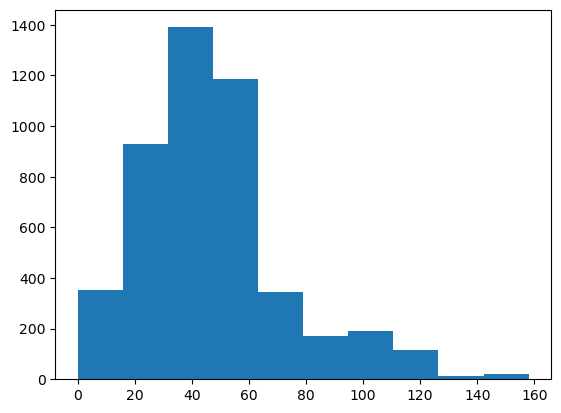

In [28]:
plt.hist([len(v) for k, v in dict_pred.items()])

In [32]:
tmp.df_val_species

In [ ]:
arr_th = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]
arr_f1 = []
for th in arr_th:
    dict_pred = tmp.create_predictions(threshold_weighted_labels=th)
    for k in dict_val_species.keys():
        if k not in dict_pred.keys():
            dict_pred[k] = []
    f1 = gpu.compute_f1_score_dicts(dict_val_species, dict_pred)
    arr_f1.append(f1)

In [55]:
print('F1 scores 20 km:')
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

F1 scores 20 km:
Th: 0.01, F1: 0.17815909998542828
Th: 0.03, F1: 0.22171562850602888
Th: 0.05, F1: 0.2550898257417876
Th: 0.07, F1: 0.2813144225923728
Th: 0.1, F1: 0.31055241911795095
Th: 0.15, F1: 0.33787610690510994
Th: 0.2, F1: 0.34126959671664947
Th: 0.3, F1: 0.29877385480062507


In [51]:
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

Th: 0.01, F1: 0.1993253455507175
Th: 0.03, F1: 0.2339567857022029
Th: 0.05, F1: 0.26306820509513906
Th: 0.07, F1: 0.2874202966047946
Th: 0.1, F1: 0.3149615778560888
Th: 0.15, F1: 0.34330129624560624
Th: 0.2, F1: 0.35171820741153903
Th: 0.3, F1: 0.32425812748704147
